## GPR Workflow for Plotting

The first large chunk contains the function to train the ML model for plotting.

Beneath it, is the step-by-step workflow to achieve gpr training. The code in this notebook is a combination of material found in `gauss_reg.ipynb`, `gpr_kernel_exploration.ipynb`, and `gpr_plot_fun.ipynb`

Authors: Sofia Ingersoll & Sujan Bhattarai 

#### Set up

In [23]:
# import libraries & data pre-processing functions from utils.py
import xarray as xr
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.metrics.pairwise import linear_kernel as Linear
from sklearn.metrics.pairwise import polynomial_kernel as Polynomial
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import norm

from ml_utils import *

In [2]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.60:41645,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


#### Data Reading & Wrangling

This calls the collection of wrangling functions in stored in the utils library, we're going to add an ifelse statement this weekend to finalize our reading & wrangling function

In [3]:
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        Ifelse Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # THIS FUNCTION IS TO BE ADDED SUNDAY 4/1/24
    # Heather's ifelse statement for reading & wrangling



    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    param = param_wrangling(param)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Subset User Selection Funct     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    var = subset_var_cluster(var)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Subset Var Wrangle Funct      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    var = wrangle_var_cluster(var)
        

    return param, var

In [4]:
param, var = dashboard_wrangling('leafcn','LNC')

In [ ]:
#param.shape

In [ ]:
#var

#### Training Emulator

**Top chunk:** strictly training, no cross validation

**Second chunk:** attempt to implement plotting general trendline

**Third chunk:** attempting to implement plotting for top 15 parameter trends

In [11]:
def train_emulator(param, var):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))

    gp_model = GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=20,
                                        random_state=42,
                                        normalize_y = True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gp_model = gp_model.fit(X_train, y_train)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gp_model.predict(X_test, return_std=True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    train_score = gp_model.score(X_train, y_train)

    # Calculate R^2
    r2_train = r2_score(y_test, y_pred)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_train
    results_df['RMSE'] = rmse_train
    
    # Print Training Metrics
    print("Training Score:", train_score)
    print("Training R^2:", r2_train)
    print("Training RMSE:", rmse_train)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        Archive Metrics       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Create a directory to store the results if it doesn't exist
    results_dir = "emulation_results"
    os.makedirs(results_dir, exist_ok=True)

    # Save the results DataFrame to a CSV file
    # CURRENT FILE NAME IS None_emulation_results
    results_file = os.path.join(results_dir, f'{var.name}_emulation_results.csv') # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    results_df.to_csv(results_file, index=False)

    # NEED TO FIX THIS, NOT OUTPUTTING PROPERLY
    # Convert DataFrame to xarray Dataset
    #ds = xr.Dataset.from_dataframe(results_df)

    # Save the results to a NetCDF file
    #nc_file = os.path.join(results_dir, f'{var}_emulation_results.nc')
    #ds.to_netcdf(nc_file)

    return results_df

In [12]:
emulation = train_emulator(param, var)

Training Score: 1.0
Training R^2: -0.005360680916129512
Training RMSE: 0.1938357032588147


#### Adding Plotting

In [27]:
from sklearn.preprocessing import MinMaxScaler

def train_emulator(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))

    gp_model = GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=20,
                                        random_state=42,
                                        normalize_y=True)

    # Scale the normalized target variable y to the desired range
    scaler = MinMaxScaler(feature_range=(20, 40))
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gp_model = gp_model.fit(X_train, y_train_scaled)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gp_model.predict(X_test, return_std=True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    train_score = gp_model.score(X_train, y_train)

    # Calculate R^2
    r2_train = r2_score(y_test, y_pred)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_train
    results_df['RMSE'] = rmse_train
    
    # Print Training Metrics
    print("Training Score:", train_score)
    print("Training R^2:", r2_train)
    print("Training RMSE:", rmse_train)

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  
    
    # Sort X_test and corresponding predictions for plotting
    sorted_indices = np.argsort(X_test[:, 0])
    X_test_sorted = X_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    y_std_sorted = y_std[sorted_indices]
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(X_test_sorted[:, 0], y_pred_sorted, color='#134611', label='GPR Prediction')
    # applying z-score for 99.7% CI
    plt.fill_between(X_test_sorted[:, 0], y_pred_sorted - z_score * y_std_sorted, y_pred_sorted + z_score * y_std_sorted, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
    plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
    plt.ylabel('Variable: Leaf Nitrogen Concentration')
    plt.title('Gaussian Process Regression Uncertainty Estimation')
    plt.legend()
    plt.show()

    return results_df

Training Score: -23245.64537161227
Training R^2: -18712.074606175396
Training RMSE: 26.445111391649775


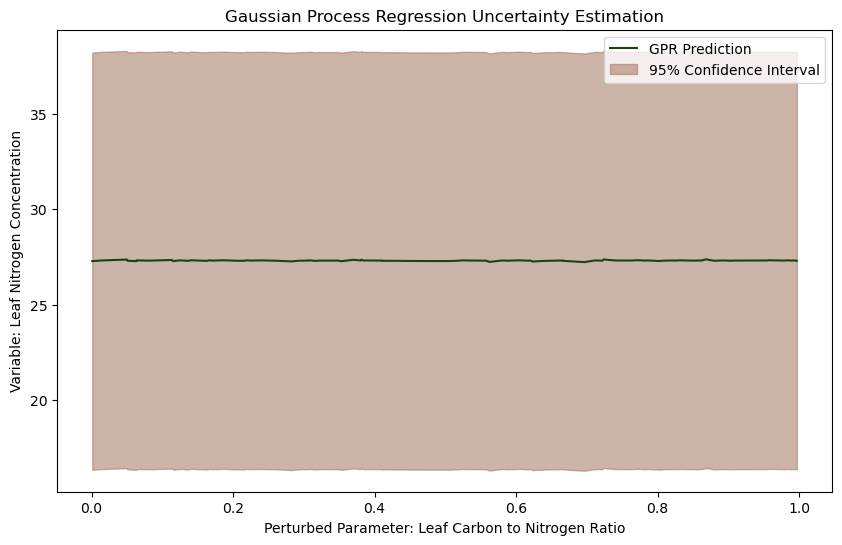

In [28]:
emulation = train_emulator(param, var)

#### Top 15 Parameters for Plotting

Sujan's Plotting Approach

In [ ]:
def train_emulator(param, var):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))

    gp_model = GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=20,
                                        random_state=42,
                                        normalize_y = True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gp_model = gp_model.fit(X_train, y_train)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Generate x_values with 32 dimensions
    # Fill array with 0.5
    x_values = np.full((10, 32), 0)  
    # Set the 15th column values to evenly spaced values from 0 to 1
    x_values[:, 15] = np.linspace(0, 1, 10)  

    # Generate y_test based on the true function
    y_test = y_test[:10]  

    
    # Make predictions
    y_pred, y_std = gp_model.predict(x_values, return_std=True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    train_score = gp_model.score(X_train, y_train)

    # Calculate R^2
    r2_train = r2_score(y_test, y_pred)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_train
    results_df['RMSE'] = rmse_train
    
    # Print Training Metrics
    print("Training Score:", train_score)
    print("Training R^2:", r2_train)
    print("Training RMSE:", rmse_train)

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Plot the actual training data against the predicted values
    plt.figure(figsize=(10, 6))

    # Plot the mean line
    plt.plot(x_values[:, 15], y_pred, color='blue', linestyle='-', label='Gaussian Regression Line')

    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  

    # Plot the shaded region for the 99.7% confidence interval with three standard deviations
    plt.fill_between(x_values[:, 15], y_pred - z_score * y_std, y_pred + z_score * y_std, color='lightblue', alpha=0.3)


    # Plot the z-score value on the plot
    plt.text(0.5, 0.5, f'99.7% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')

    plt.scatter(X_test[:, 15], y_pred, color='red', label='Training Data')
    plt.xlabel('Emulated Variable')
    plt.ylabel('Selected Parameter (set to 1, other parameters to 0.5)')
    plt.title('Actual Training Data vs Gaussian Regression Line with 99.7% Confidence Interval')
    plt.legend()
    plt.show()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        Archive Metrics       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Create a directory to store the results if it doesn't exist
    results_dir = "emulation_results"
    os.makedirs(results_dir, exist_ok=True)

    # Save the results DataFrame to a CSV file
    # CURRENT FILE NAME IS None_emulation_results
    results_file = os.path.join(results_dir, f'{var.name}_emulation_results.csv') # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    results_df.to_csv(results_file, index=False)

    # NEED TO FIX THIS, NOT OUTPUTTING PROPERLY
    # Convert DataFrame to xarray Dataset
    #ds = xr.Dataset.from_dataframe(results_df)

    # Save the results to a NetCDF file
    #nc_file = os.path.join(results_dir, f'{var}_emulation_results.nc')
    #ds.to_netcdf(nc_file)

    return results_df

In [ ]:
emulation = train_emulator(param, var)

In [ ]:
emulation

#### Visualizing Emulator

In [ ]:
## 15 index is selected because it is a leafn in dataset.
from scipy.stats import norm

# Define a custom function to generate the Gaussian regression line
def gaussian_regression_line(model, X):
    # Generate x_values with 32 dimensions
    x_values = np.full((10, 32), 0)  # Fill array with 0.5
    x_values[:, 15] = np.linspace(0, 1, 10)  # Set the 15th column values to evenly spaced values from 0 to 1

    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_pred, y_std = model.predict(x_values, return_std=True)

    # Plot the mean line
    plt.plot(x_values[:, 15], y_pred, color='blue', linestyle='-', label='Gaussian Regression Line')

    # Calculate the z-score for the 99.7% confidence interval
    z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

    # Plot the shaded region for the 99.7% confidence interval with three standard deviations
    plt.fill_between(x_values[:, 15], y_pred - z_score * y_std, y_pred + z_score * y_std, color='lightblue', alpha=0.3)


    # Plot the z-score value on the plot
    plt.text(0.5, 0.5, f'99.7% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')

    # Plot the actual training data against the predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test[:, 15], y_pred, color='red', label='Training Data')
    gaussian_regression_line(gp_model, X_test)
    plt.xlabel('Leafcn values between 0 and 1')
    plt.ylabel('leafn  set to 1, rest all parameters to 0.5')
    plt.title('Actual Training Data vs Gaussian Regression Line with 99.7% Confidence Interval')
    plt.legend()
    plt.show()

In [ ]:
gaussian_regression_line(emulation, X_test)